Исследование гипотезы применения подхода с использованием градиентного бустинга с lag фичами

1. Загрузка и подготовка данных...
Загружено строк: 1091043
Строк после преобразования дат: 1091043
Пропущенных значений в датах: 0
Пропущенных значений в суммах: 0
Удалено строк с пропусками: 0
Осталось строк: 1091043

2. Создание временных лагов и признаков...


C:\Users\Mi\AppData\Local\Temp\ipykernel_7276\445869134.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M', on='service_date').agg({
c:\Python312\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
[I 2025-04-02 04:25:32,141] A new study created in memory with name: no-name-7164507d-ede7-4a6d-9998-c7529672db81


Строк после агрегации по месяцам: 24
Удалено месяцев с пропусками: 1
Осталось месяцев: 23

Запуск оптимизации гиперпараметров...


Best trial: 6. Best value: 7.43829e+06:  45%|████▌     | 9/20 [00:00<00:00, 59.91it/s]

[I 2025-04-02 04:25:32,179] Trial 0 finished with value: 19262656.184210528 and parameters: {'n_estimators': 278, 'max_depth': 6, 'learning_rate': 0.2380541322253218, 'num_leaves': 34, 'min_child_samples': 23}. Best is trial 0 with value: 19262656.184210528.
[I 2025-04-02 04:25:32,191] Trial 1 finished with value: 19262656.184210528 and parameters: {'n_estimators': 274, 'max_depth': 4, 'learning_rate': 0.0713978343556322, 'num_leaves': 25, 'min_child_samples': 21}. Best is trial 0 with value: 19262656.184210528.
[I 2025-04-02 04:25:32,200] Trial 2 finished with value: 19262656.184210528 and parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.01149438588278974, 'num_leaves': 11, 'min_child_samples': 12}. Best is trial 0 with value: 19262656.184210528.
[I 2025-04-02 04:25:32,210] Trial 3 finished with value: 19262656.184210528 and parameters: {'n_estimators': 167, 'max_depth': 3, 'learning_rate': 0.20228572628776778, 'num_leaves': 41, 'min_child_samples': 24}. Best is tr

Best trial: 6. Best value: 7.43829e+06:  55%|█████▌    | 11/20 [00:00<00:00, 59.91it/s]

[I 2025-04-02 04:25:32,321] Trial 10 finished with value: 9351671.522096336 and parameters: {'n_estimators': 87, 'max_depth': 8, 'learning_rate': 0.031056298900868445, 'num_leaves': 21, 'min_child_samples': 6}. Best is trial 6 with value: 7438288.098521467.
[I 2025-04-02 04:25:32,352] Trial 11 finished with value: 9972876.563534953 and parameters: {'n_estimators': 68, 'max_depth': 8, 'learning_rate': 0.02988668009637061, 'num_leaves': 21, 'min_child_samples': 5}. Best is trial 6 with value: 7438288.098521467.


Best trial: 6. Best value: 7.43829e+06:  65%|██████▌   | 13/20 [00:00<00:00, 47.25it/s]

[I 2025-04-02 04:25:32,405] Trial 12 finished with value: 10817235.314845204 and parameters: {'n_estimators': 68, 'max_depth': 7, 'learning_rate': 0.02338541432047096, 'num_leaves': 50, 'min_child_samples': 5}. Best is trial 6 with value: 7438288.098521467.
[I 2025-04-02 04:25:32,462] Trial 13 finished with value: 19262656.184210528 and parameters: {'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.0426642340878619, 'num_leaves': 21, 'min_child_samples': 11}. Best is trial 6 with value: 7438288.098521467.


Best trial: 6. Best value: 7.43829e+06:  75%|███████▌  | 15/20 [00:00<00:00, 47.25it/s]

[I 2025-04-02 04:25:32,509] Trial 14 finished with value: 19262656.184210528 and parameters: {'n_estimators': 243, 'max_depth': 8, 'learning_rate': 0.01993746283731933, 'num_leaves': 37, 'min_child_samples': 10}. Best is trial 6 with value: 7438288.098521467.
[I 2025-04-02 04:25:32,562] Trial 15 finished with value: 19262656.184210528 and parameters: {'n_estimators': 226, 'max_depth': 6, 'learning_rate': 0.15753013710030475, 'num_leaves': 24, 'min_child_samples': 15}. Best is trial 6 with value: 7438288.098521467.


Best trial: 6. Best value: 7.43829e+06:  90%|█████████ | 18/20 [00:00<00:00, 29.99it/s]

[I 2025-04-02 04:25:32,620] Trial 16 finished with value: 8785497.683944091 and parameters: {'n_estimators': 121, 'max_depth': 7, 'learning_rate': 0.04730873927128906, 'num_leaves': 16, 'min_child_samples': 8}. Best is trial 6 with value: 7438288.098521467.
[I 2025-04-02 04:25:32,665] Trial 17 finished with value: 19262656.184210528 and parameters: {'n_estimators': 132, 'max_depth': 7, 'learning_rate': 0.1383920751862716, 'num_leaves': 15, 'min_child_samples': 16}. Best is trial 6 with value: 7438288.098521467.


Best trial: 6. Best value: 7.43829e+06: 100%|██████████| 20/20 [00:00<00:00, 31.25it/s]
C:\Users\Mi\AppData\Local\Temp\ipykernel_7276\445869134.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = model.predict(X_test)


[I 2025-04-02 04:25:32,731] Trial 18 finished with value: 8375451.647609923 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.05788867388806812, 'num_leaves': 50, 'min_child_samples': 9}. Best is trial 6 with value: 7438288.098521467.
[I 2025-04-02 04:25:32,780] Trial 19 finished with value: 19262656.184210528 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06129694972189566, 'num_leaves': 50, 'min_child_samples': 14}. Best is trial 6 with value: 7438288.098521467.
Лучшие параметры: {'n_estimators': 240, 'max_depth': 8, 'learning_rate': 0.0638457681141381, 'num_leaves': 48, 'min_child_samples': 8}

Обучение финальной модели...

Метрики качества на тестовой выборке:
MAE: 7438288.10
MSE: 84265386726894.72
MAPE: 5.84%


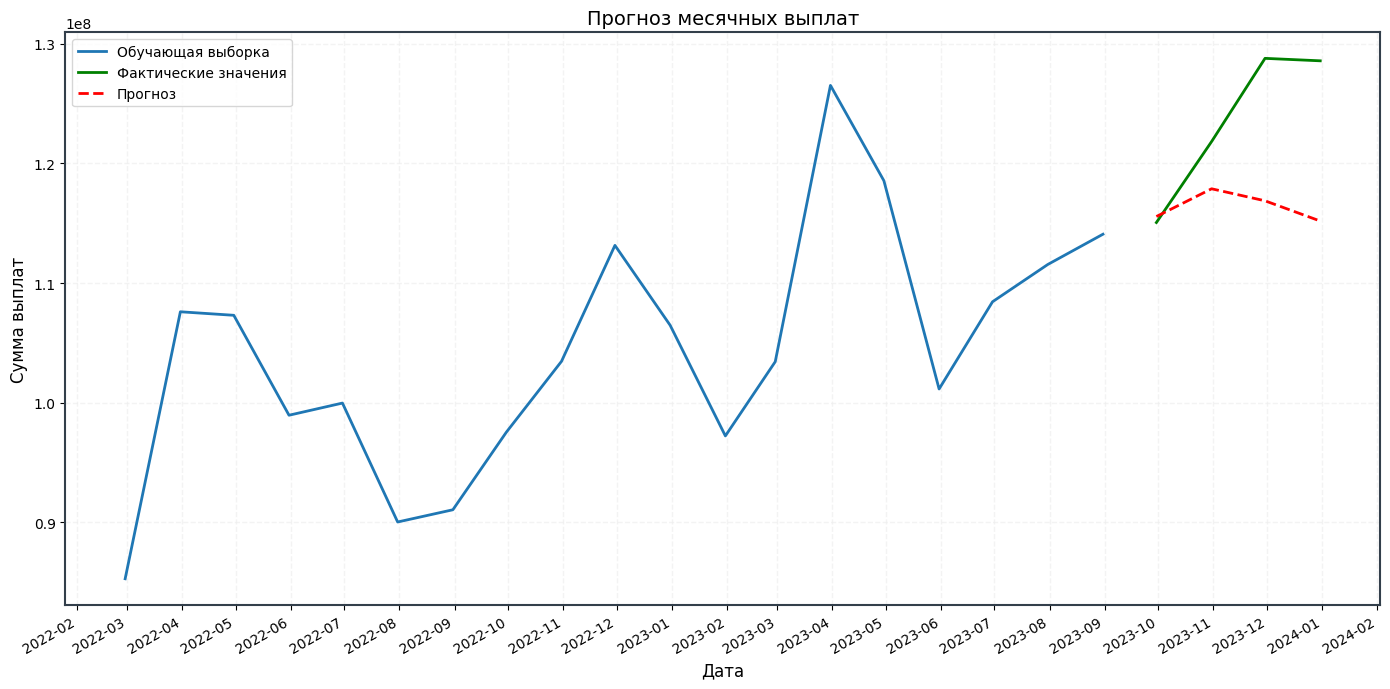


7. Прогноз на будущие периоды с помесячной привязкой...


C:\Users\Mi\AppData\Local\Temp\ipykernel_7276\445869134.py:208: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(


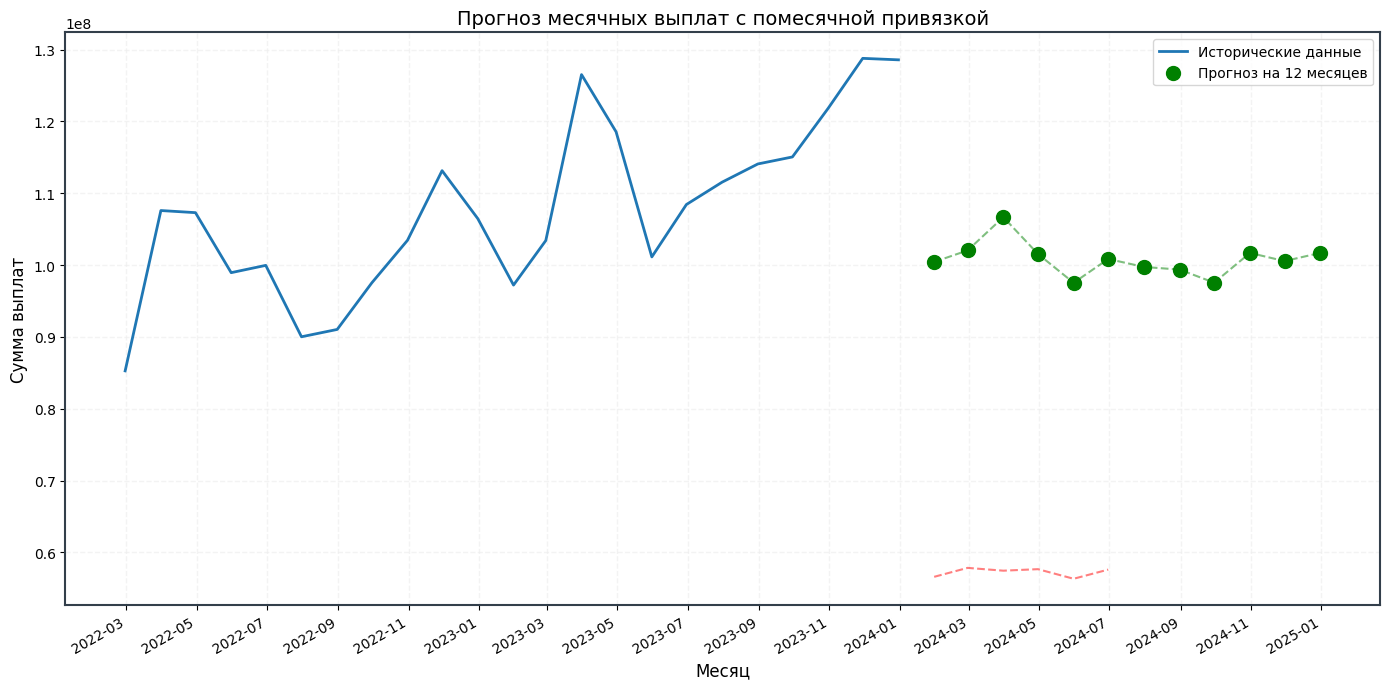


Прогноз на 12 месяцев:
  Месяц      Прогноз
2024-01 1.004482e+08
2024-02 1.020475e+08
2024-03 1.066789e+08
2024-04 1.015683e+08
2024-05 9.754113e+07
2024-06 1.008555e+08
2024-07 9.975131e+07
2024-08 9.937815e+07
2024-09 9.755810e+07
2024-10 1.017013e+08
2024-11 1.005626e+08
2024-12 1.017013e+08


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing

# 1. Загрузка и подготовка данных
print("1. Загрузка и подготовка данных...")
try:
    # Загрузка данных из CSV файла
    data = pd.read_csv(r"D:\repositories\cup_it_25\CupIT_Sber_data.csv", delimiter=";", decimal=',')
    print(f"Загружено строк: {len(data)}")
except Exception as e:
    raise ValueError(f"Ошибка при загрузке файла: {e}")

# Преобразование типов данных
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'], errors='coerce')

# Проверка данных после преобразования
print(f"Строк после преобразования дат: {len(data)}")
print(f"Пропущенных значений в датах: {data['service_date'].isna().sum()}")
print(f"Пропущенных значений в суммах: {data['service_amount_net'].isna().sum()}")

# Удаление строк с пропусками в ключевых полях
initial_count = len(data)
data = data.dropna(subset=['service_date', 'service_amount_net'])
print(f"Удалено строк с пропусками: {initial_count - len(data)}")
print(f"Осталось строк: {len(data)}")

if len(data) == 0:
    raise ValueError("Нет данных для анализа после очистки. Проверьте исходные данные.")

# 2. Создание временных лагов и признаков
print("\n2. Создание временных лагов и признаков...")

# Агрегация данных по месяцам
try:
    monthly_data = data.resample('M', on='service_date').agg({
        'service_amount_net': 'sum',
        'service_document_id': 'count',
        'patient_id': 'nunique'
    }).rename(columns={
        'service_document_id': 'transactions_count',
        'patient_id': 'unique_patients'
    })
    print(f"Строк после агрегации по месяцам: {len(monthly_data)}")
except Exception as e:
    raise ValueError(f"Ошибка при агрегации по месяцам: {e}")

if len(monthly_data) == 0:
    raise ValueError("Нет данных после агрегации по месяцам. Проверьте диапазон дат.")

# Динамическое создание лагов в зависимости от размера данных
max_reasonable_lag = min(12, len(monthly_data) // 2)  # Максимальный лаг = половина данных
lags = [1, 2, 3, 6, 9, 12]
lags = [lag for lag in lags if lag <= max_reasonable_lag]

for lag in lags:
    monthly_data[f'lag_{lag}'] = monthly_data['service_amount_net'].shift(lag)

# Скользящие статистики с динамическими окнами
rolling_windows = [3, 6, 12]
rolling_windows = [w for w in rolling_windows if w <= len(monthly_data)]

for window in rolling_windows:
    monthly_data[f'rolling_mean_{window}'] = monthly_data['service_amount_net'].rolling(window).mean()
    monthly_data[f'rolling_std_{window}'] = monthly_data['service_amount_net'].rolling(window).std()

# Разности и процентные изменения
monthly_data['diff'] = monthly_data['service_amount_net'].diff()
monthly_data['pct_change'] = monthly_data['service_amount_net'].pct_change()

# Временные признаки
monthly_data['month'] = monthly_data.index.month
monthly_data['year'] = monthly_data.index.year
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data['days_in_month'] = monthly_data.index.days_in_month

# Тригонометрические признаки для учета сезонности
monthly_data['sin_month'] = np.sin(2 * np.pi * monthly_data['month'] / 12)
monthly_data['cos_month'] = np.cos(2 * np.pi * monthly_data['month'] / 12)

# Экспоненциальное сглаживание
if len(monthly_data) >= 3:  # Нужно минимум 3 точки для сглаживания
    monthly_data['exp_smooth'] = SimpleExpSmoothing(monthly_data['service_amount_net']).fit(smoothing_level=0.2).fittedvalues

# Декомпозиция временного ряда (требуется минимум 2 полных периода)
if len(monthly_data) >= 24:
    decomposition = seasonal_decompose(monthly_data['service_amount_net'], model='additive', period=12)
    monthly_data['trend'] = decomposition.trend
    monthly_data['seasonal'] = decomposition.seasonal
    monthly_data['residual'] = decomposition.resid

# Удаление строк с пропусками (оставляем строки с хотя бы 50% заполненных признаков)
initial_monthly_count = len(monthly_data)
monthly_data = monthly_data.dropna(thresh=len(monthly_data.columns)//2)
print(f"Удалено месяцев с пропусками: {initial_monthly_count - len(monthly_data)}")
print(f"Осталось месяцев: {len(monthly_data)}")

if len(monthly_data) < 6:
    raise ValueError(f"Недостаточно данных для моделирования. Доступно только {len(monthly_data)} месяцев.")

# 3. Разделение данных на обучающую и тестовую выборки
test_size = max(3, int(len(monthly_data) * 0.2))  # Минимум 3 месяца в тесте
train = monthly_data.iloc[:-test_size]
test = monthly_data.iloc[-test_size:]

X_train = train.drop('service_amount_net', axis=1)
y_train = train['service_amount_net']
X_test = test.drop('service_amount_net', axis=1)
y_test = test['service_amount_net']

# 4. Оптимизация гиперпараметров с помощью Optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'verbosity': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

# Запуск оптимизации только если достаточно данных
if len(X_train) > 10:
    print("\nЗапуск оптимизации гиперпараметров...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    best_params = study.best_params
    print("Лучшие параметры:", best_params)
else:
    print("\nНедостаточно данных для оптимизации гиперпараметров. Используем параметры по умолчанию.")
    best_params = {
        'objective': 'regression',
        'n_estimators': 100,
        'max_depth': 4,
        'learning_rate': 0.1,
        'num_leaves': 20,
        'min_child_samples': 10
    }

# 5. Обучение финальной модели
print("\nОбучение финальной модели...")
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
test['forecast'] = model.predict(X_test)

# Расчет метрик качества
mae = mean_absolute_error(y_test, test['forecast'])
mse = mean_squared_error(y_test, test['forecast'])
mape = np.mean(np.abs((y_test - test['forecast']) / y_test)) * 100

print("\nМетрики качества на тестовой выборке:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 6. Визуализация результатов
plt.figure(figsize=(14, 7))

# Исторические данные
plt.plot(train.index, train['service_amount_net'], 
         label='Обучающая выборка', linewidth=2)

# Фактические значения тестовой выборки
plt.plot(test.index, test['service_amount_net'], 
         label='Фактические значения', color='green', linewidth=2)

# Прогноз на тестовой выборке
plt.plot(test.index, test['forecast'], 
         label='Прогноз', color='red', linestyle='--', linewidth=2)

# Настройка отображения дат
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_data)//12)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('Прогноз месячных выплат', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 7. Прогнозирование на будущие периоды с явной привязкой к месяцам
print("\n7. Прогноз на будущие периоды с помесячной привязкой...")

if len(monthly_data) >= 6:
    # Получаем последнюю дату из исторических данных
    last_date = monthly_data.index[-1]
    
    # Создаем DataFrame для хранения прогнозов с правильными датами
    forecast_dates = pd.date_range(
        start=last_date + pd.offsets.MonthBegin(1),
        periods=12,  # Максимум 12 месяцев прогноза
        freq='M'
    )
    
    # Делаем прогноз на 12 месяцев
    
    forecast_12m = make_forecast(
        model=model,
        last_date=last_date,
        last_values=monthly_data['service_amount_net'],
        steps=12
    )
    
    # Визуализация с явной привязкой к месяцам
    plt.figure(figsize=(14, 7))
    
    # Исторические данные
    plt.plot(monthly_data.index, monthly_data['service_amount_net'], 
             label='Исторические данные', linewidth=2)
    
    
    # Прогноз на 12 месяцев (все 12 точек)
    plt.scatter(
        forecast_dates, 
        forecast_12m['forecast'].values,
        color='green', s=100, label='Прогноз на 12 месяцев', zorder=5
    )
    
    # Соединяем точки линиями для наглядности
    plt.plot(forecast_dates[:6], forecast_6m['forecast'].values[:6], 
             'r--', alpha=0.5)
    plt.plot(forecast_dates, forecast_12m['forecast'].values, 
             'g--', alpha=0.5)
    
    # Настройка отображения дат
    all_dates = list(monthly_data.index) + list(forecast_dates)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(all_dates)//12)))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    
    plt.title('Прогноз месячных выплат с помесячной привязкой', fontsize=14)
    plt.xlabel('Месяц', fontsize=12)
    plt.ylabel('Сумма выплат', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    
    print("\nПрогноз на 12 месяцев:")
    print(pd.DataFrame({
        'Месяц': forecast_dates.strftime('%Y-%m'),
        'Прогноз': forecast_12m['forecast'].values
    }).to_string(index=False))
else:
    print("Недостаточно данных для построения прогноза (нужно минимум 6 месяцев исторических данных)")

**Вывод**: Гипотеза не оправдалась. На предсказании в 12 месяцев не отслеживается тренд и сезонность


Тест Льюнга-Бокса для остатков LightGBM модели:
    lb_stat  lb_pvalue
1  0.712220   0.398708
2  2.956864   0.227995
3  6.169660   0.103641

Значение p-value: 0.1036

Вывод: p-value > 0.05 → Нет оснований отвергать нулевую гипотезу.
Остатки модели не демонстрируют значимой автокорреляции, что свидетельствует
об адекватности модели и хорошем учете временной структуры данных.


<Figure size 1200x500 with 0 Axes>

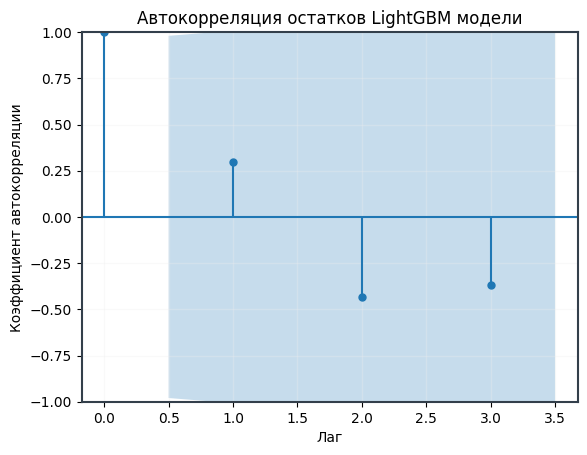

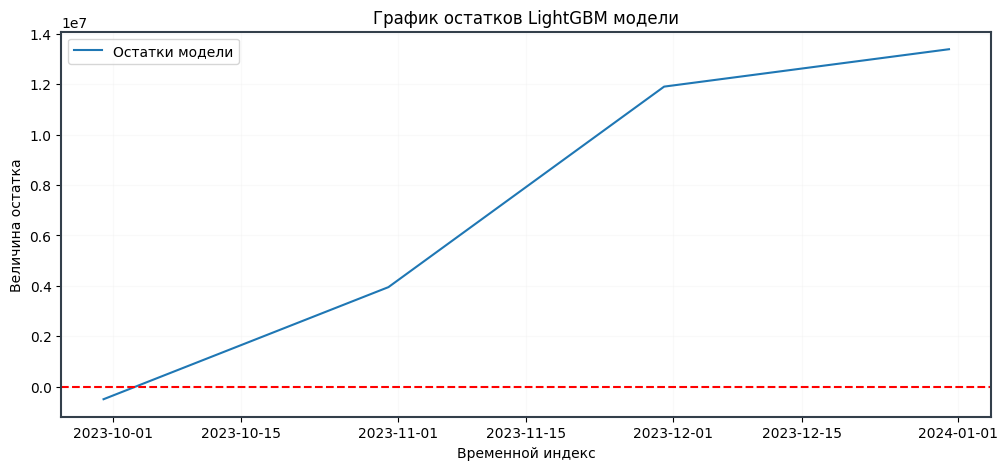

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# 1. Получение остатков модели
residuals = y_test - test['forecast']

# 2. Автоматический подбор максимального количества лагов
max_possible_lags = min(12, len(residuals) - 1)  # Не больше 12 и не больше len(residuals)-1

# 3. Тест Льюнга-Бокса
if max_possible_lags > 0:
    print("\nТест Льюнга-Бокса для остатков LightGBM модели:")
    lb_test = acorr_ljungbox(residuals, lags=max_possible_lags, return_df=True)
    print(lb_test)
    
    # 4. Анализ p-value
    p_value = lb_test['lb_pvalue'].iloc[-1]
    print(f"\nЗначение p-value: {p_value:.4f}")
    
    # 5. Интерпретация результатов
    if p_value > 0.05:
        print("\nВывод: p-value > 0.05 → Нет оснований отвергать нулевую гипотезу.")
        print("Остатки модели не демонстрируют значимой автокорреляции, что свидетельствует")
        print("об адекватности модели и хорошем учете временной структуры данных.")
    else:
        print("\nВывод: p-value ≤ 0.05 → Отвергаем нулевую гипотезу.")
        print("Остатки содержат значимую автокорреляцию, что указывает на:")
        print("- Неучтенные временные зависимости в модели")
        print("- Возможную необходимость добавления дополнительных лагов")
        print("- Недостаточное количество признаков для описания сезонности")
        
    # 6. Визуализация автокорреляции остатков
    plt.figure(figsize=(12, 5))
    plot_acf(residuals, lags=max_possible_lags, alpha=0.05, title='Автокорреляция остатков LightGBM модели')
    plt.xlabel('Лаг')
    plt.ylabel('Коэффициент автокорреляции')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 7. Дополнительная диагностика: график остатков
    plt.figure(figsize=(12, 5))
    plt.plot(residuals, label='Остатки модели')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('График остатков LightGBM модели')
    plt.xlabel('Временной индекс')
    plt.ylabel('Величина остатка')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\nНедостаточно данных для выполнения теста Льюнга-Бокса (требуется минимум 2 наблюдения).")

# 8. Рекомендации по улучшению модели (если найдена автокорреляция)
if 'p_value' in locals() and p_value <= 0.05:
    print("\nРекомендации по улучшению модели:")
    print("1. Добавьте больше временных лагов (lag_12, lag_24)")
    print("2. Включите сезонные фичи (месяц, квартал)")
    print("3. Попробуйте добавить скользящие статистики за 12 месяцев")
    print("4. Рассмотрите комбинацию с ARIMA для моделирования остатков")
    print("5. Увеличьте глубину дерева (max_depth) для лучшего учета долгосрочных зависимостей")